In [102]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
from keras.layers import Input, Convolution1D, Flatten, Dense, Dropout, Embedding
from keras.optimizers import Adam, SGD
import tensorflow as tf

In [103]:
#Hyper Parameters
FILE_NAME = "../../Data/processed_data.csv"
CNN_LAYER_SIZE =50
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.2
VERBOSE = 1
HIDDEN_ACTIVATION_FUNCTION = 'relu'
OUTPUT_ACTIVATION_FUNCTION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS=['accuracy']
Y_LABEL_NAME="author"
X_LABEL_NAME="text"

In [104]:
#Defining model
def define_model(input_size, output_size, verbose = True, cnn_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    
    inputs = Input(shape = (1,input_size))
    dense1 = Convolution1D(filters = cnn_layer_size, kernel_size = 1, activation=hidden_activation_fn)(inputs)
    flat1 = Flatten()(dense1)

    output = Dense(units=output_size, activation=output_activation_fn)(flat1)
  
    
    # Create model
    model = Model(inputs = [inputs], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = SGD(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model

In [105]:
#Read data
data = pd.read_csv(FILE_NAME)

In [106]:
#Get corpus and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [107]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [108]:
#Transform data into tfidf representation
count_vec = CountVectorizer(binary=False)
X_train = count_vec.fit_transform(text_train).astype('float32')
X_test = count_vec.transform(text_test).astype('float32')


X_train = X_train.toarray()
X_test = X_test.toarray()

#Get input and output dimensions
input_size = X_train.shape[1]
output_size = len(author.unique())

In [109]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [110]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(15663, 23230)
(3916, 23230)
(15663,)
(3916,)


In [111]:
X_train = X_train[:,None]
X_test = X_test[:,None]

In [112]:
print(np.shape(X_train))
print(np.shape(X_test))

(15663, 1, 23230)
(3916, 1, 23230)


In [113]:
# X_train = np.reshape(X_train,( -1,23230,1))
# X_test= np.reshape(X_test,( -1,23230,1))

X_train = np.reshape(X_train,( -1,1,23230))
X_test= np.reshape(X_test,( -1,1,23230))

In [114]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    cnn_model = define_model(input_size= input_size, output_size= output_size, verbose = False,
                      cnn_layer_size = CNN_LAYER_SIZE, hidden_activation_fn = HIDDEN_ACTIVATION_FUNCTION,
                      output_activation_fn = OUTPUT_ACTIVATION_FUNCTION, learning=LEARNING_RATE, loss_function = LOSS_FUNCTION, metrics=METRICS)

    histroy = cnn_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = cnn_model.predict(X_test)
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
294/294 [==============================] - 4s 12ms/step - loss: 0.8830 - accuracy: 0.5970 - val_loss: 0.8068 - val_accuracy: 0.6325
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 0.6607 - accuracy: 0.7269 - val_loss: 0.6349 - val_accuracy: 0.7359
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 0.5342 - accuracy: 0.7846 - val_loss: 0.6047 - val_accuracy: 0.7474
Epoch 4/10
294/294 [==============================] - 3s 11ms/step - loss: 0.4294 - accuracy: 0.8304 - val_loss: 0.7562 - val_accuracy: 0.6967
Epoch 5/10
294/294 [==============================] - 3s 11ms/step - loss: 0.3558 - accuracy: 0.8639 - val_loss: 0.5835 - val_accuracy: 0.7809
Epoch 6/10
294/294 [==============================] - 3s 11ms/step - loss: 0.2559 - accuracy: 0.9094 - val_loss: 0.5727 - val_accuracy: 0.7809
Epoch 7/10
294/294 [==============================] - 3s 11ms/step - loss: 0.2186 - accuracy: 0.9242 - val_loss: 0.5747 - val_accuracy:

In [115]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.7677051413006469
Average Precision across K-folds: 0.7843888061090104
Average Recall across K-folds: 0.7677051413006469
Average F1 Score across K-folds: 0.764740430690135
Average Training Time across K-folds: 31.907000064849854 seconds
Prediction Time across K-folds: 0.2889988422393799 seconds


In [116]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


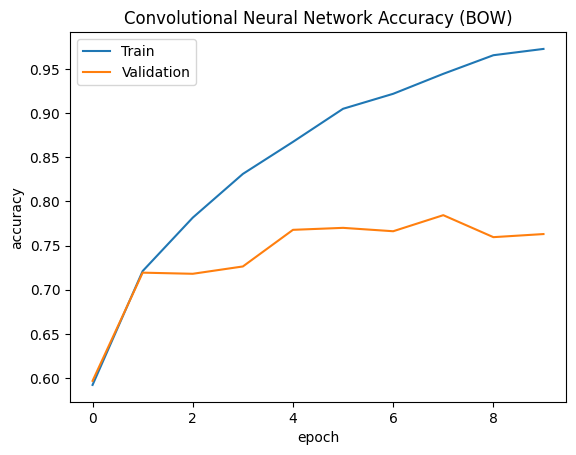

In [117]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Convolutional Neural Network Accuracy (BOW)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network_bow_acc.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


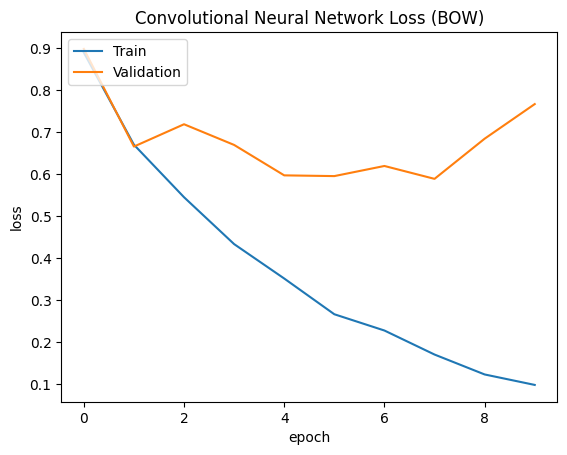

In [118]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Convolutional Neural Network Loss (BOW)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network__bow_loss.eps", format='eps')
plt.show()